## Loading the data & cleaning (if necessary)

# **Spotify Popularity Prediction**

 By: Chad Rivera, Cheng Wu, Kyle Kirejczyk

## Import all the libraries

In [9]:

#importing everything from the hw's 
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.cm as cm
import statistics
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from ISLP import load_data
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score,classification_report, f1_score, recall_score, precision_score
import math
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
#from sklearn.preprocessing import StandardScale
import random   
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier



## Loading the data & cleaning (if necessary)

In [10]:
#import everything
df = pd.read_csv("top_10000_1950-now.csv")

#a = df.describe
#a= df.columns
#print(a)

#oh cleaning is definetley necessary
#dropping the useless columns. 
df.drop(columns=['Track URI', 'Artist URI(s)', 'Album URI','Album Name', 'Album Artist URI(s)', 
        'Album Artist Name(s)', 'Album Image URL',
        'Disc Number', 'Track Number','Track Preview URL','ISRC', 'Artist Genres', #matt said to drop artist genre lol
        'Added By', 'Added At','Album Genres', 'Label', 'Copyrights'], axis=1, inplace=True)
#print(df.columns)

#dropping rows that don't have enough values lol
df = df.dropna(subset=['Danceability'])


#fixing the columns that literally have 5 values missing :)
fixableFiveColumns = ['Danceability', 'Energy', 'Key','Loudness','Mode', 'Speechiness',
'Acousticness', 'Instrumentalness', 'Liveness', 'Valence','Tempo', 'Time Signature']

for i in fixableFiveColumns:
    daMean = df[i].mean()
    #df[i].fillna(daMean)
    df[i] = df[i].fillna(daMean)



#now the Albumn Release Date
#we just have to grab the first 4 digits bc that's the year
df['Album Release Date'] = df['Album Release Date'].astype(str).str[:4].astype(int)
#to check it 
#df['Album Release Date'].head()


#now the explicit column. convert to binary
df['Explicit'] = df['Explicit'].astype(int)
#df['Explicit'].head()


# Filter the new isPopular column. 
thresh = 51 #51% gives the best confusion matrix, but 58% accuracy
df["isPopular"] = ((df['Popularity'] >= thresh).astype(int))

#let's try songs with popularity <=5
df = df[df['Popularity'] > 5]
df = df.reset_index(drop=True)





## Logistic Regression model!

In [11]:
#define the axises
x= df.drop(columns=['Popularity', 'Track Name','Artist Name(s)', "isPopular", "Tempo", "Speechiness", "Mode", "Time Signature", "Key"] )#this list will continue growing lol
y = df["isPopular"]

#split the data up 50%, 25% 25%
X_temp, X_holdout, y_temp, y_holdout = train_test_split(
    x, y, test_size=0.25, random_state=44) #in memory of the wendy's 4 for 4 meal

#Split temp into train (50%) & test (25%)
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp, test_size=0.3333, random_state=44)



print(x.shape[1])
print(y.nunique())



10
2


In [12]:
#I'm going to use the logit instead of LinearRegression. Logit is better for p-values

xTrainConst = sm.add_constant(X_train)


logitModel = sm.Logit(y_train, xTrainConst)
result = logitModel.fit()

print(result.summary())





Optimization terminated successfully.
         Current function value: 0.666215
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              isPopular   No. Observations:                 3372
Model:                          Logit   Df Residuals:                     3361
Method:                           MLE   Df Model:                           10
Date:                Mon, 28 Apr 2025   Pseudo R-squ.:                 0.03809
Time:                        20:39:40   Log-Likelihood:                -2246.5
converged:                       True   LL-Null:                       -2335.4
Covariance Type:            nonrobust   LLR p-value:                 6.364e-33
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  45.4963      5.670      8.024      0.000      34.384      56.609
Al

Testing the logistic model on the testing data now

In [13]:

#we want an ROC curve here too.
ypredProbs = result.predict(sm.add_constant(X_test))
yPredBinary = (ypredProbs >= 0.5).astype(int)


#print the confusion matrix
#    |   TN- high  FP- low  |
 #1  |   FN- low   TP- high  |

print(confusion_matrix(y_test, yPredBinary))


#Evaluating da performance
print("Accuracy:", accuracy_score(y_test, yPredBinary))
print(classification_report(y_test, yPredBinary))

#Currently it is 4% accurate :(
#NOW 67% ACCURATE BUT IT'S NOT TRULY WORKING
#53% but the matrix looks alot better
#BOOM SWITCHED TO LOGIT & WE GOT A 67.6 ACCURACY




[[557 303]
 [405 421]]
Accuracy: 0.5800711743772242
              precision    recall  f1-score   support

           0       0.58      0.65      0.61       860
           1       0.58      0.51      0.54       826

    accuracy                           0.58      1686
   macro avg       0.58      0.58      0.58      1686
weighted avg       0.58      0.58      0.58      1686



In [14]:
# Bin valence into 5 buckets
df['valence_bin'] = pd.cut(df['Valence'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Group by bins and calculate mean popularity
valence_grouped = df.groupby('valence_bin')['Popularity'].mean()

print(valence_grouped)




valence_bin
(0.0, 0.2]    49.346154
(0.2, 0.4]    48.579032
(0.4, 0.6]    49.128205
(0.6, 0.8]    47.832518
(0.8, 1.0]    46.610356
Name: Popularity, dtype: float64


/tmp/ipykernel_1451/404129331.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valence_grouped = df.groupby('valence_bin')['Popularity'].mean()


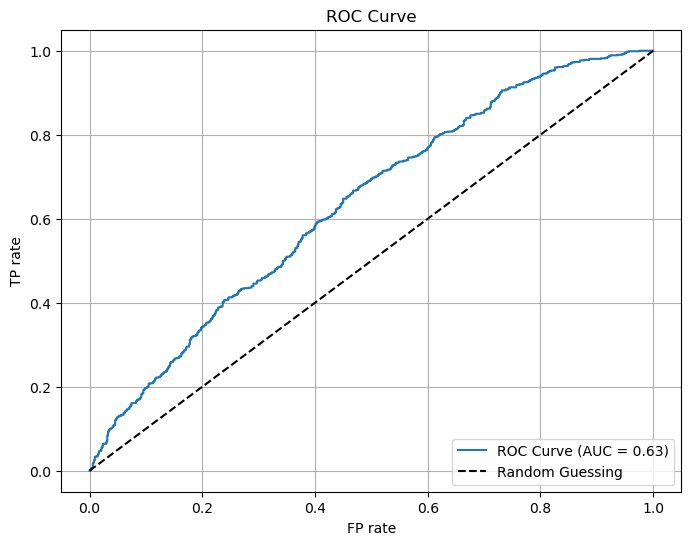

In [15]:
y_pred_prob = result.predict(sm.add_constant(X_test))  # if using statsmodels Logit

# 2. Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# 3. Compute AUC (Area Under Curve)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# 4. Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)


In [16]:
features_to_bin = [
    'Album Release Date',
    'Track Duration (ms)',
    'Danceability',
    'Energy',
    'Loudness',
    'Acousticness',
    'Instrumentalness',
    'Liveness'
]

# Create a dictionary to store results
binned_feature_popularity = {}

# Loop through each feature
for feature in features_to_bin:
    # 1. Bin feature into 5 equal-width buckets
    df[f'{feature}_bin'] = pd.cut(df[feature], bins=5)
    
    # 2. Group by bin and calculate mean popularity
    grouped = df.groupby(f'{feature}_bin')['Popularity'].mean()
    
    # 3. Store results
    binned_feature_popularity[feature] = grouped

# Display results
for feature, grouped in binned_feature_popularity.items():
    print(f"\nFeature: {feature}")
    print(grouped)


Feature: Album Release Date
Album Release Date_bin
(1954.931, 1968.8]    48.718033
(1968.8, 1982.6]      52.528133
(1982.6, 1996.4]      48.393792
(1996.4, 2010.2]      45.503182
(2010.2, 2024.0]      48.863561
Name: Popularity, dtype: float64

Feature: Track Duration (ms)
Track Duration (ms)_bin
(58591.96, 360301.0]      48.147608
(360301.0, 660509.0]      45.791667
(660509.0, 960717.0]            NaN
(960717.0, 1260925.0]     48.000000
(1260925.0, 1561133.0]    47.000000
Name: Popularity, dtype: float64

Feature: Danceability
Danceability_bin
(-0.000988, 0.198]    41.045455
(0.198, 0.395]        45.297297
(0.395, 0.593]        46.920628
(0.593, 0.79]         48.593867
(0.79, 0.988]         52.549080
Name: Popularity, dtype: float64

Feature: Energy
Energy_bin
(-0.000977, 0.199]    43.178571
(0.199, 0.399]        45.584121
(0.399, 0.598]        47.962729
(0.598, 0.798]        49.184804
(0.798, 0.997]        47.775435
Name: Popularity, dtype: float64

Feature: Loudness
Loudness_bin
(-

/tmp/ipykernel_1451/449669938.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(f'{feature}_bin')['Popularity'].mean()
/tmp/ipykernel_1451/449669938.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(f'{feature}_bin')['Popularity'].mean()
/tmp/ipykernel_1451/449669938.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(f'{feature}_bin')['Popularity'].me